# Functions to Evaluate Recommendation Models
- Personalization

- Average Raitings with User Recommendation

- Precision at k, Recal at k

- Personal diversity

- General Diversity - Are we recommending unpopular movies

- average of average ratings

### Import Recommendation System

1)  Convert recommendation system notebook to .py

2) Import function here using:

from <name.py> import <name of the recomendation function>
    
example: from contentbasedrecommendationsystem import user_content_recommendations
    
3) recommendation_system: give the name of the recommendation system, you want to get the evaluations for

### Content System Versions
- content_initial_eval (processed_df_sparse): genre, actor, director. Cosine similarity between movies
- contentv2_noMovieNorm_eval (processed_df_sparse): same data, but no normalization of movie vector (true for all others)
- content_desc_eval (processed_df_desc): top 5 TF-IDF tokens from movie description
- content_desc_genre (processed_df_desc_genre_sparse): description tokens and genre
- content_all_meta_eval (processed_df_all_meta_sparse): genre, actor, director, decade, production company 
    - Systems with each individual feature in the "all" version: content_ (genre, actors_directors, decade, production) _eval
- content_tags_eval (processed_df_tags_sparse): top 5 TF-IDF genome tags


In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import operator
import scipy.spatial.distance as distance
from sklearn import metrics 
import random
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import fastparquet
import pickle
import scipy
import sklearn
from content_based_recommendations import user_content_recommendations

## Load Data

In [2]:
df = scipy.sparse.load_npz("processed_df_all_meta_sparse.npz")
#df = scipy.sparse.load_npz("processed_df_sparse.npz")
ratings = pd.read_pickle('ratings_sample.pkl')
ratings = ratings.reset_index()
movies_raitings = pd.read_parquet('movies_ratings.parq')
movies_raitings = movies_raitings.rename(columns={"avg": "Average_Ratings"})

In [3]:
with open('sparse_metadata_all_meta', "rb") as f:
    cols = pickle.load(f)
    movieIds = pickle.load(f)
#with open('sparse_metadata', "rb") as f:
#    cols = pickle.load(f)
#    movieIds = pickle.load(f)

In [4]:
#index = [cols.index(i) for i in cols if i.startswith('production')]
#df = df[:, index]
#cols = [cols[i] for i in index]

## Helper Fns

In [5]:
def user_top(movies,n):
    return movies[['title_eng','Average_Ratings']][:n]

def user_movie_id(movies,n):
    return movies['movieId'][:n]

def user_avg_rating(movies,n):
    return movies['Average_Ratings'][:n]

## Specify recommendation system

In [6]:
recommendation_system = user_content_recommendations

## Open file to record evaluations

In [7]:
f = open("evaluations/content_production_eval.txt", "w")

## Evaluation: Personalization



In [8]:
"""
get_users_prediction: returns user prediction

user_matrix: generated user by movies, 0: movie not recommended, 1: movie got recommended

"""
def get_users_prediction(users_list,top_n,users_prediction,recommendation_system, df, ratings, movieIds):
    for i in users_list:
        recommendation = recommendation_system(i, df, ratings, movieIds)
        prediction = user_movie_id(recommendation,top_n).astype(int).values
        users_prediction = users_prediction.append(pd.Series(prediction),ignore_index=True)
        
    return users_prediction

def user_matrix(users_pred):
    data_melt= pd.DataFrame(data=users_pred).reset_index().melt(id_vars='index', value_name='movieId',)
    data_melt = data_melt[['index', 'movieId']].pivot(index='index', columns='movieId', values='movieId')
    cols = data_melt.columns
    for i in cols:
        data_melt[i] = np.where(data_melt[i].isna(), 0, 1)
    return data_melt


def personalization(users_matrix,n):
    # generating cosine similarity between the users
    #then getting the indicies of elements above diagonal (giving diagonal offsert =1 in triu_indices)
    #calculating the avg of the element above diagonal 
    #Personalization means 1 - similarity
    #higher the personalization score, better the recommendation system in recommending personalized movies
   
    users_sim = metrics.pairwise.cosine_similarity(users_matrix)
    iu1 = np.triu_indices(n,k=1)
    similarity_avg = np.mean(users_sim[iu1])
    personalization_score = 1 - similarity_avg

    return personalization_score

def cross_fold_eval(unique_users,recommendation_system,k_fold=10,n=10,top_n=10):
    #users_list: List of random n users
    
    kfold_personalization=0
    for i in range(k_fold):
        users_list = random.sample(unique_users, n)
        
        #columns: top_n recommendations
        #users_prediction:  top_n recommendations for n users
        column_names = list(range(top_n))
        users_prediction = pd.DataFrame(columns = column_names)
        
        # getting predictions for sampled users
        users_pred = get_users_prediction(users_list,top_n,users_prediction,recommendation_system, df, ratings, movieIds)
        
        # getting user by movies matrix with binary indicators 0: movie not recommended, 1: movie got recommended
        users_matrix = user_matrix(users_pred)
        kfold_personalization+=personalization(users_matrix,n)
    kfold_eval = kfold_personalization/k_fold
    print(f'Personalization score for {k_fold} folds across {n} users for top {top_n} recommendations: {kfold_eval}', file = f)

In [9]:
"""
    unique_users: getting unique user set 
    
    default values given in function
    n: number of users 
    top_n: top number of recommendations (10)
    recommendation_system: Name of the recommendation system
    
"""

unique_users = set(ratings.userId)
start_time = time.time()
cross_fold_eval(unique_users,recommendation_system, n = 20)

#end_time = time.time() - start_time
#print(f'Time take {end_time} seconds')

# Precision and Recall 

### Keeping the users who have rated minimum of 20 movies

- n_users: Number of users to filter the from the dataset

In [10]:
user_list = ratings.groupby('userId')['userId'].count().reset_index(name="rating_count")
users_list = set(user_list[user_list['rating_count']>=20]['userId'].values)
print(f' Number of users who rated at least 20 movies: {len(users_list)}')

 Number of users who rated at least 20 movies: 115856


In [11]:
random.seed(42)
n_users = 1000
random_users = random.sample(users_list, n_users)
users_ratings = ratings[ratings.userId.isin(random_users)]
len(users_ratings)

95207

### train/test split - Keeping the users distribution similar

In [12]:
# creating train/test empty dataframe

train = pd.DataFrame(columns=['index','userId', 'movieId', 'rating','timestamp'])
test = pd.DataFrame(columns=['index','userId', 'movieId', 'rating','timestamp'])

In [13]:
# spliting each user data equally in train test
for i in random_users:
    #getting individual user index
    random_index =set(users_ratings[users_ratings['userId'] == i].index.values)
    
    # dividing the user ratings count/2
    n_len = np.math.floor(len(random_index)/2)
    

    # getting index for train data
    train_ind = set(random.sample(random_index, n_len))

    # getting index for test data by removing train index from all index for that user
    test_ind = set(random_index-train_ind)
    

    # getting data for that user
    df_train = users_ratings.loc[train_ind]
    df_test = users_ratings.loc[test_ind]
    # appending that user data to train/test df
    
    train = train.append(df_train)
    test = test.append(df_test)

#### Train Records

In [14]:
train.shape

(47341, 5)

#### Test Records

In [15]:
test.shape

(47866, 5)

#### random sample a user from train set

In [16]:
n = 20
top_n = 10
random.seed(42)
train_user_id = set(train.userId.values)
random_userId = random.sample(train_user_id, n)
random_userId[0]

122124

In [17]:
def calc_precision_k(recommended_relevant_count,recommended_count):
    precision_k = recommended_relevant_count/recommended_count
    return precision_k

def calc_recall_k(recommended_relevant_count,relevant_count):
    if relevant_count==0:
        return 0
    else:
        recall_k = recommended_relevant_count/relevant_count
        return recall_k
    
def avg_precision_recall(random_userId,top_n,k):
    avg_precision=[]
    avg_recall =[]
    tot_rec_rel = []
    for i in random_userId:
        recommendation = recommendation_system(i, df, train, movieIds)
        # getting the recommended movies @k
        recommended_movies = set(recommendation[:k].movieId)

        # number of recommended movie @k
        recommended_count = k
        # getting relevant movies, where ratings >=

        relevant_movies =set(test[(test['userId']==i) & (test['rating']>=2) ]['movieId'].values)
        # Total number of relevant movie
        relevant_count = len(relevant_movies)
        # Getting movies that are relevant and recommended
        recommended_relevant_movies = recommended_movies.intersection(relevant_movies)
        # number of relevant recommended movies
        recommended_relevant_count = len(recommended_relevant_movies)
        precision_k = calc_precision_k(recommended_relevant_count,recommended_count)
        recall_k = calc_recall_k(recommended_relevant_count,relevant_count)
        avg_precision.append(precision_k)
        avg_recall.append(recall_k)
        tot_rec_rel.append(recommended_relevant_count)
    precision_avg = np.mean(avg_precision)
    recall_avg = np.mean(avg_recall)
    rec_rel_avg = np.mean(tot_rec_rel)

    return precision_avg,recall_avg, rec_rel_avg

## Getting Precision and Recall for n user


### Relevant item: Has in test with rating >= 3
### Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)

### Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)

In [18]:
k = 5
precision_k,recall_k, rec_rel_avg = avg_precision_recall(random_userId,top_n,k)
print(f'Avg Precision at {k} for {n} users: {precision_k}', file = f)
print(f'Avg Recall at {k} for {n} users: {recall_k}', file = f)
print(f'Avg Number of relevant recommendations at {k} for {n} users: {rec_rel_avg}', file = f)

In [19]:
k = 10
precision_k,recall_k, rec_rel_avg = avg_precision_recall(random_userId,top_n,k)
print(f'Avg Precision at {k} for {n} users: {precision_k}', file = f)
print(f'Avg Recall at {k} for {n} users: {recall_k}', file = f)
print(f'Avg Number of relevant recommendations at {k} for {n} users: {rec_rel_avg}', file = f)

In [20]:
k = 30
precision_k,recall_k, rec_rel_avg = avg_precision_recall(random_userId,top_n,k)
print(f'Avg Precision at {k} for {n} users: {precision_k}', file = f)
print(f'Avg Recall at {k} for {n} users: {recall_k}', file = f)
print(f'Avg Number of relevant recommendations at {k} for {n} users: {rec_rel_avg}', file = f)

# Diversity

## Personal Diversity: 

### Calculate for n users and then do an average.


In [21]:
def personal_diversity(top_n,n,list_user):
    random.seed(42)
    rand_user = random.sample(list_user, n)  
    length = len(rand_user)
    # storing diversity for n users
    diversity =[]
    for u in range(length):
        # getting recommended movies
        recommendation = recommendation_system(rand_user[u], df, ratings, movieIds)
        prediction = user_movie_id(recommendation,top_n).astype(int).values
        predicted_index = [movieIds.index(i) for i in prediction]        
        user_df = df[predicted_index, :]
        user_movie_features = pd.DataFrame()
        
        # getting only the columns that have any value 1
        for i in range(len(prediction)):
            nonzero_cols = [cols[j] for j in user_df[i,:].nonzero()[1]]
            d = {k:1 for k in nonzero_cols}
            d = pd.DataFrame(data = d, index = [prediction[i]])    
            user_movie_features = pd.concat([user_movie_features, d])

        # replace NaN with 0
        user_movie_features = user_movie_features.fillna(0)
        
        # generating cosine similarity between the users
        #then getting the indicies of elements above diagonal (giving diagonal offsert =1 in triu_indices)
        #calculating the avg of the element above diagonal 
        sim = metrics.pairwise.cosine_similarity(np.asmatrix(user_movie_features))

        iu1 = np.triu_indices(user_movie_features.shape[0],k=1)
        avg = 1 - np.mean(sim[iu1])
        
        print(f'Diversity of movies recommended for user {rand_user[u]}: {avg}')
        diversity.append(avg)
        
    # calculating avg diversity over n users
    avg_diversity = np.mean(diversity)
    print(avg_diversity)
    print(f'Average diversity over {n} users for their top {top_n} recommendations (0 = identical): {avg_diversity}', file = f)

In [22]:
"""
top_n: top n recommendations
n: number of users

Ignore warning for now - comming from recommendatiom function
Fixed the one from this function
"""

top_n = 10
n = 20
list_user = set(ratings.userId)

personal_diversity(top_n,n,list_user)
# function call for personal diversity

Diversity of movies recommended for user 29185: 0.0
Diversity of movies recommended for user 6557: 0.6
Diversity of movies recommended for user 72099: 0.0
Diversity of movies recommended for user 64198: 0.0
Diversity of movies recommended for user 58515: 0.37777777777777777
Diversity of movies recommended for user 36580: 0.0
Diversity of movies recommended for user 26869: 0.0
Diversity of movies recommended for user 142970: 0.3555555555555555
Diversity of movies recommended for user 22791: 0.0
Diversity of movies recommended for user 154800: 0.0
Diversity of movies recommended for user 110607: 0.0
Diversity of movies recommended for user 8332: 0.0
Diversity of movies recommended for user 7812: 0.0
Diversity of movies recommended for user 24562: 0.0
Diversity of movies recommended for user 57316: 0.0
Diversity of movies recommended for user 60992: 0.0
Diversity of movies recommended for user 132479: 0.0
Diversity of movies recommended for user 157821: 0.0
Diversity of movies recommended

## Average Rating 


### Get average rating for n users

1) Getting the top_n ratings of movies recommended to n users.

2) Averaging over the all the ratings

In [23]:
"""
n: number of users
top_n: top n movie recommendations

"""

list_user = set(ratings.userId)
n = 20
top_n = 10

In [24]:
random.seed(42)
rand_user = random.sample(list_user, n)  
length = len(rand_user)
avg_rating = []
for u in range(length):
    # getting recommended movies
    recommendation = recommendation_system(rand_user[u], df, ratings, movieIds)
    recommendation_rating = pd.merge(recommendation, movies_raitings, on = 'movieId')
    prediction = user_avg_rating(recommendation_rating,top_n).values
    avg_rating.append(prediction)

In [25]:
print(f'Average movie rating of top {top_n} movies recommended to {n} users: {np.round(np.mean(avg_rating),2)}', file = f)

In [26]:
ranges = ['0-1', '1-2', '2-3', '3-4', '4-5']
ad = pd.DataFrame(avg_rating).melt()
ad['ratingrange'] = pd.cut(ad['value'], bins=[0,1,2,3,4,5], labels=ranges, right=True)

Text(0.5, 1.0, 'Ratings - Recommended Movies')

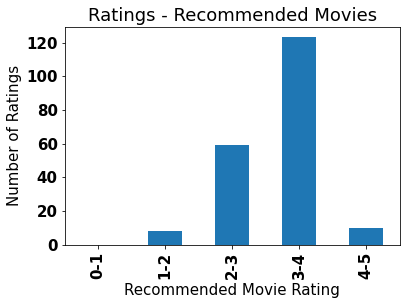

In [27]:
font = {'weight' : 'bold',
        'size'   : 15}
plt.rc('font', **font)

ax = ad.groupby(['ratingrange'])['ratingrange'].count().plot.bar()
ax.set_ylabel('Number of Ratings')
ax.set_xlabel('Recommended Movie Rating')
ax.set_title('Ratings - Recommended Movies')

# Checking for the long tail

- to check are we recommending unpopular movies?

In [28]:
n = 20
top_n = 10
random.seed(42)
rand_user = random.sample(list_user, n)  
length = len(rand_user)
top_n
min_cnt = []

for u in range(length):
    # getting recommended movies
    recommendation = recommendation_system(rand_user[u], df, ratings, movieIds)
    recommendation_rating = pd.merge(recommendation, movies_raitings, on = 'movieId')

    # getting the min rating cnt of the movies recommended
    min_rating_cnt = recommendation_rating[:top_n]['cnt'].min()
    min_cnt.append(min_rating_cnt)

avg_min_cnt = np.mean(min_cnt)

In [29]:
print(f"Average of the minimum count of ratings for {n} user's top {top_n} recommendations (long tail): {np.round(avg_min_cnt,2)}", file = f)

## Close File

In [30]:
f.close()